In [1]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Imports

In [2]:
!pip install umap-learn
!pip install transformers
!pip install sentence-transformers

from sentence_transformers import SentenceTransformer, util
import umap.umap_ as umap
import pandas as pd
import numpy as np
from statistics import mean

import torch
import torch.nn as nn

from nltk.cluster import KMeansClusterer, cosine_distance

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer

import os
from collections import defaultdict

from nltk import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
import re
import nltk
nltk.download('wordnet')

from wordcloud import WordCloud
import matplotlib.pyplot as pl

from sklearn.neighbors import NearestCentroid
from scipy.stats import stats
from pandas import DataFrame

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Preprocessing

* Please refer to the notebook for TF-IDF for the preprocessing steps

## Create chunks of 300 words
* The goal of this part is to preprocess the dataset. Tweets were concatenated at the author level. It created documents of more then 512 tokens. As SBERT cannot deal with documents of more than 512 tokens, we decided to split each documents into chunks of 300 words.

In [3]:
%cd "/content/drive/My Drive/Research Assistant/Paper"
df = pd.read_csv("100_tweets.csv")
df["tweet_len"] = df.Tweets.apply(lambda x: len(x.split()))
print(df.tweet_len.mean())
print(df.tweet_len.median())
print(df.tweet_len.max())
print(df.tweet_len.min())

/content/drive/My Drive/Research Assistant/Paper
1306.666089965398
1321.0
2620
360


In [4]:
def split_tweets(tweet: str, n: int):
  """
  Separate the tweets from a same author into different paragraphs of n words.

  Args:
  -------
  tweet: the tweet you want to split.
  n: the number of words per paragraph.

  Returns:
  -------
  tweets: list of the paragraphs generated.

  """
  tweet = tweet.split()
  tweets = [" ".join(tweet[i:i+n]) for i in range(0, len(tweet), n)]
  
  return tweets

In [5]:
# apply split_tweets to all the rows of our dataframe
df.Tweets = df.Tweets.apply(lambda x: split_tweets(x,300))

In [6]:
# create a row for each chunck of document
df = df.explode("Tweets",ignore_index=True)

In [7]:
# save the data
df.to_csv("100_tweets_explode.csv", index=False)

# Generate embeddings for each chunks
* The performance of the embedding generated by sentence-bert is highly dependent of the pretrained model used (see https://www.sbert.net/docs/pretrained_models.html#model-overview to check the different possibilities). After trying a couple of different models we found out that the best was all-mpnet-base-v2. 

In [8]:
def get_embeddings(queries, model_name = 'all-mpnet-base-v2'):
  
  model = SentenceTransformer(model_name)
  model.max_seq_length = 400
  print("Start encoding queries")
  queries_embedding = model.encode(queries, convert_to_tensor=False)

  return queries_embedding

In [9]:
df = pd.read_csv("100_tweets_explode.csv")

#create the embeddings (might be very slow if you don't have a gpu)
embeddings = get_embeddings(df.Tweets.values)

Start encoding queries


In [10]:
# save the embeddings
torch.save(embeddings, "100_embeddings_explode.pt")

# Clustering


In [11]:
def average_silhouette(embedding : list, n_clusters: int = 6):
    """ 
    Use KMeans to cluster the embedding and then compute the average
    silhouette score.
    
    Args:
    -------------
    embedding: sentence embedding from bert
    n_clusters: the number of clusters you want to split your data in
    
    Returns:
    -------------
    silhouette_avg: the average silhouette score
    model.score: score of the KMeans model
    cluster_labels : numpy array of labels
    """
    model_scores = [] 
    model_silhouettes = []

    # model = KMeans(n_clusters= n_clusters, init='k-means++', n_init=1)
    model = KMeansClusterer(n_clusters, distance=cosine_distance,repeats=25, avoid_empty_clusters=True)
    cluster_labels = model.cluster(embedding, assign_clusters=True)

    silhouette_avg = silhouette_score(embedding, cluster_labels)
    print(f'Avg silhouette score is {silhouette_avg}')

    return model, cluster_labels

def plot_top_n_words(top_n_words: dict, n: int):
  """

  Simple function to print the top n words of a cluster based on
  c-TF-IDF, a notion introduced in BERTopics.

  Args:
  --------
  top_n_words : dictionary with key the clusters and values a list of words
  n : the number of words you want to print for each cluster

  Returns:
  --------
  Nothing

  """
  for cluster in range(6):
    print(f"Cluster number {cluster} topic:")
    print(top_n_words[cluster][:n])
    print("\n")

# Code taken from https://github.com/KIZI/evaluation-of-comprehensibility/blob/master/clustering_analysis_v2/LINVILLWARREN-AlternativeA-full.ipynb.ipynb
def contingencytable (data, cluster_labels,true_labels):
    colors = ["blue","pink","black","green","yellow","violet","red","grey"]

    df = pd.DataFrame({'cluster': cluster_labels,
                       'category': true_labels})
    newdf = df.groupby(by=["cluster","category"]).size().unstack().reset_index().drop("cluster",axis=1)
    newdf = newdf.rename_axis("cluster",axis="columns")
    ax = newdf.plot.bar(stacked=True,color=colors)
    ax.set_ylabel("account count")
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
              fancybox=True, shadow=True, ncol=5)
       
def purity_silhouette(data, cluster_labels,true_labels):
    sil=silhouette_samples(data, cluster_labels)
    silbycluster=[]
    purbycluster=[]
    for i in np.unique(cluster_labels):
        silbycluster.append(np.mean(sil[cluster_labels==i]))
        purbycluster.append(purity_score(np.array(true_labels)[cluster_labels==i],cluster_labels[cluster_labels==i]))
    silbycluster     = np.round(np.array(silbycluster),2)
    purbycluster     = np.round(np.array(purbycluster),2)
    return(pd.DataFrame([silbycluster,purbycluster], index=["silhouette","purity"]))

# Code taken from https://github.com/KIZI/evaluation-of-comprehensibility/blob/master/clustering_analysis_v2/LINVILLWARREN-AlternativeA-full.ipynb.ipynb
def purity_score(y_true, y_pred):
    contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix)

# Code modified from https://towardsdatascience.com/topic-modeling-with-bert-779f7db187e6
def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count

# Code modified from https://towardsdatascience.com/topic-modeling-with-bert-779f7db187e6
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, column: str ,n = 20):
    words = count.get_feature_names()
    labels = list(docs_per_topic[column])
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

class TrollTfidfVectorizer(TfidfVectorizer):

    def __init__(self, *args, **kwargs):
        troll_stop_words = {'don', 'just', 'like'} # the custom stop word list could be further expanded
        kwargs['stop_words'] = set(ENGLISH_STOP_WORDS).union(troll_stop_words)
        kwargs['preprocessor'] = self.vectorizer_preprocess
        self.wnl = WordNetLemmatizer()
        super(TrollTfidfVectorizer, self).__init__(*args, **kwargs)

    def build_analyzer(self):
        analyzer = super(TfidfVectorizer, self).build_analyzer()
        return lambda doc: ([self.wnl.lemmatize(w) for w in analyzer(doc)])

    def vectorizer_preprocess(self, s):
        # remove urls
        s = re.sub(r'(https?|ftp)://(-\.)?([^\s/?\.#-]+\.?)+(/[^\s]*)?', '', s)
        # remove amp
        s = s.replace('&amp;', '')
        # remove RT signs (no meaning) but keep username
        s = re.sub(r'\bRT\b\s+', '', s)
        s = s.lower()
        return s

In [12]:
# load the dataset 
df = pd.read_csv("100_tweets_explode.csv")
# load the embedding
emb = torch.load("100_embeddings_explode.pt")

In [13]:
# There might be a better choice of hyperparameter
umap_embeddings = umap.UMAP(n_components= 4,
                            n_neighbors=15,
                            random_state = 42,
                            min_dist = 0.01,
                            metric='cosine').fit_transform(emb)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


In [14]:
model, cluster_labels = average_silhouette(umap_embeddings)
df["cluster_labels"] = cluster_labels

Avg silhouette score is 0.33407726883888245


In [15]:
# necessary step in order to calculate the silhouette score on umap_embeddings
umap_df = pd.DataFrame(umap_embeddings)
df = pd.concat([df,umap_df],axis=1)
df.columns = ["index",	"authors",	"Tweets",	"Labels",	"tweet_len", "cluster_labels", "umap1", "umap2", "umap3", "umap4"	]
df.head()

,index,authors,Tweets,Labels,tweet_len,cluster_labels,umap1,umap2,umap3,umap4
0,0,10_GOP,'@realDonaldTrump We have your back Mr. Presid...,RightTroll,1601,4,2.343519,9.449767,10.526603,-2.377125
1,0,10_GOP,https://t.co/fwvN1Jek8L Remember how Media was...,RightTroll,1601,4,2.202449,9.241184,10.458537,-2.328672
2,0,10_GOP,a question about “white guilt” posed by a repo...,RightTroll,1601,4,1.154457,9.691688,10.160256,-1.982995
3,0,10_GOP,he gave up on his career. CNN has zero integri...,RightTroll,1601,4,1.848255,10.374053,11.057726,-2.323753
4,0,10_GOP,"petition, help us stop Twitter censorship! #1A...",RightTroll,1601,4,1.094259,9.767428,10.515782,-1.760439


In [16]:
# documents were separated into chuncks. We need to come back to the initial configuration
aggregation = df.groupby("authors").agg({"cluster_labels":lambda x:x.value_counts().index[0], "Labels": lambda x:x.value_counts().index[0], "Tweets": lambda x: " ".join(x), "umap1": lambda x: np.mean(x), "umap2": lambda x: np.mean(x), "umap3": lambda x: np.mean(x), "umap4": lambda x: np.mean(x)}).reset_index()
aggregation.head()

,authors,cluster_labels,Labels,Tweets,umap1,umap2,umap3,umap4
0,10_GOP,4,RightTroll,'@realDonaldTrump We have your back Mr. Presid...,1.849055,9.741154,10.554412,-2.178968
1,4MYSQUAD,2,LeftTroll,fuck that older brother is in trooooooouble ht...,-1.297544,8.198288,8.859731,-1.725271
2,AANTIRACIST,4,LeftTroll,Kneel down and pray & know #God is has already...,0.678267,7.544878,8.640838,-1.460925
3,ABIGAILSSILK,0,HashtagGamer,#RetireASongOrBand Silver Surfin' USA #Vulnera...,3.305641,6.375966,5.892393,-2.558975
4,ABIISSROSB,4,RightTroll,#abi Trump’s Approval Rating LEAPS! https://t....,1.737210,8.988907,10.965265,-1.814941


In [17]:
purity_silhouette(aggregation[["umap1","umap2","umap3", "umap4"]].values, aggregation.cluster_labels, aggregation.Labels)

,0,1,2,3,4,5
silhouette,0.74,0.59,0.54,0.50,0.04,0.26
purity,0.83,0.62,1.00,0.58,0.75,0.93


# Wordclouds

In [18]:
MIN_DF = 0.4 #as in the original experiment for user study
MAX_FEATURES= None
dataset_to_process = "MANNHEIM"
MAX_WORDS_WORDCLOUD =100

# Generate the doc_term_matrix
vectorizer = TrollTfidfVectorizer(max_features=MAX_FEATURES, min_df=MIN_DF)
doc_term_matrix = vectorizer.fit_transform(aggregation.Tweets.values)
doc_term_matrix

<578x102 sparse matrix of type '<class 'numpy.float64'>'
	with 32562 stored elements in Compressed Sparse Row format>

In [19]:
def wordcloud(dataframe, path, spectral=False, max_words=200,vertical =1,  horizontal =6):
    if dataframe.shape[0] == 5:
        vertical =1
        horizontal =5
    
    clusters_word_freq = []

    for index, row in dataframe.iterrows():
        freq_dict = {}
        for col_name in dataframe.columns:
            if row[col_name] > 0.00001:
                freq_dict[col_name] = float(row[col_name])
        clusters_word_freq.append(freq_dict)

    fig = pl.figure(figsize=(20, 10))
    for cluster, freq_dict in enumerate(clusters_word_freq):
        if spectral: #used for wordclouds from zscores, coolwarm goes from blue to red 
            def color_func(word, *args, **kwargs):
                cmap = pl.cm.get_cmap('coolwarm')
                #Colormap instances are used to convert data values (floats) from the interval [0, 1] to the RGBA color
                rgb = cmap(freq_dict[word] / 100, bytes=True)[0:3]                    
                return rgb
        else:
            color_func = None

        ax = fig.add_subplot(vertical, horizontal, cluster + 1)
        cloud = WordCloud(normalize_plurals=False,
                          background_color='white', color_func=color_func,max_words=max_words, random_state=42)
        #classwordcloud.WordCloud(font_path=None, width=400, height=200, margin=2, ranks_only=None, prefer_horizontal=0.9, mask=None, scale=1, color_func=None, max_words=200, min_font_size=4, stopwords=None, random_state=None, background_color='black', max_font_size=None, font_step=1, mode='RGB', relative_scaling='auto', regexp=None, collocations=True, colormap=None, normalize_plurals=True, contour_width=0, contour_color='black', repeat=False, include_numbers=False, min_word_length=0, collocation_threshold=30)
        cloud.generate_from_frequencies(frequencies=freq_dict)
        ax.imshow(cloud, interpolation='bilinear')
        ax.set_yticks([])
        ax.set_xticks([])
        ax.text(0.35, 1, f'Cluster {cluster}',
                 fontsize=32, va='bottom',transform=ax.transAxes)
    fig.show()
    ax.figure.savefig(path+'.pdf',bbox_inches='tight')

In [20]:
def top_terms(df, top_n=5):
    return df.sum().sort_values(ascending=False).head(top_n)

def dfFromModel(model,vectorizer, doc_term_matrix, clusters):
    
    dataframe = DataFrame(doc_term_matrix.todense(),columns=vectorizer.get_feature_names())
    dataframe["labels"] = aggregation.cluster_labels

    return dataframe.groupby('labels').mean()

def dfFromModel_Zscore(cluster_centers, transformation = None):
    if transformation == None:
        transformed=cluster_centers
    elif transformation=="zscore" or  transformation=="zscore_rescaled":
        zscore=stats.zscore(cluster_centers, axis=0)
        if transformation=="zscore_rescaled":
            #data are flattened into one long vector
            zscore_flattened = zscore.reshape(zscore.shape[0] * zscore.shape[1], 1)
            #rescaled
            #MinMaxScaler preserves the shape of the original distribution.
            scaler = MinMaxScaler((0,100))
            # find maximum absolute z score 
            bound = max(max(zscore_flattened), abs(min(zscore_flattened)))
            # use the maximum z score to create transformation centered around 0
            scaler.fit(np.array([-bound,bound]))
            #scaler.fit(zscore_flattened) # originaly the transformation was fitted without the centering
            #owing to the centering, after the transformation, value 50 corresponds to zscore 0 
            zscore_flattened_scaled = scaler.transform(zscore_flattened)
            #and transformed back to the original shape
            zscore_scaled = zscore_flattened_scaled.reshape(zscore.shape[0], zscore.shape[1])
            transformed=zscore_scaled
        else:
            transformed=zscore
    dataframe = DataFrame(transformed, columns=vectorizer.get_feature_names())
    return(dataframe)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


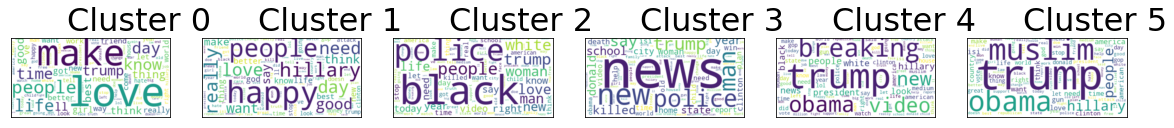

In [21]:
wordcloud(dfFromModel(model,vectorizer, doc_term_matrix, cluster_labels),"wordclouds_"+dataset_to_process + "_INTERNAL",max_words=MAX_WORDS_WORDCLOUD)

In [22]:
# required step to create the wordcloud based on the z-score
features = pd.DataFrame(doc_term_matrix.toarray())
aggregation = pd.concat([aggregation, features],axis=1)
aggregation = aggregation.groupby("cluster_labels").mean().reset_index(drop = True)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


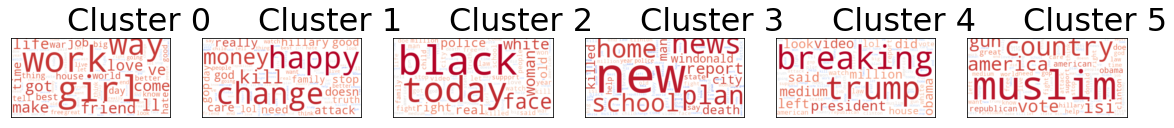

In [23]:
wordcloud(dfFromModel_Zscore(aggregation.drop(["umap1","umap2","umap3","umap4"],axis=1).values.tolist(),"zscore_rescaled"),"wordclouds_z_"+dataset_to_process+"_INTERNAL", spectral=True,max_words=MAX_WORDS_WORDCLOUD)